In [1]:
from matplotlib import pyplot
import numpy as np
from ultralytics import YOLO
from PIL import Image
def cal_entropy(prob):
    """
    calculate entropy of each defect
    """
    entropy = -1 * np.sum(prob * np.log2(prob))
    return entropy


def cal_entropy_one_image(img_path, model, times):
    img_path_list = [img_path for i in range(times)]
    results = model(img_path_list)
    entropy = []
    for re in results:
        cls_all = re.cls_all
        if len(cls_all) != 0:
            cls_all = np.array(cls_all.cpu())
            entropy_sum = 0
            for i in range(len(cls_all)):
                entropy_sum += cal_entropy(cls_all[i])
            entropy.append(entropy_sum / len(cls_all)) 
        
        #plot
        im_array = re.plot()  # plot a BGR numpy array of predictions
        im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
        # plot img
        pyplot.imshow(im_array)
        pyplot.show()     
                
    entropy_mean = np.mean(np.array(entropy))
    
    return entropy_mean, results


# model = YOLO('yolov8-dropblock.yaml').load('/Data4/student_zhihan_data/data/GC10-DET/test/images/img_08_425391700_00198_jpg.rf.79baed4ea8e426615cf676e94acf6292.jpg')
model = YOLO('/Data4/student_zhihan_data/source_code/yolo/ultralytics/runs/detect/GC10-DET_brightness_0 detect by yolov8n with dropout(p=0.1)/weights/best.pt')

In [2]:

img_path = img_path = '/Data4/student_zhihan_data/data/GC10-DET_brightness_10/test/images/img_08_425391700_00198_jpg.rf.79baed4ea8e426615cf676e94acf6292.jpg'
results = model([img_path for i in range(400)])

# cal_entropy_one_image(img_path, model, 20)
# img_path = '/Data4/student_zhihan_data/data/GC10-DET_brightness_-150/test/images/img_08_425391700_00198_jpg.rf.79baed4ea8e426615cf676e94acf6292.jpg'
# cal_entropy_one_image(img_path, model, 200)


0: 640x640 4 oil_spots, 1: 640x640 2 inclusions, 2 oil_spots, 2: 640x640 (no detections), 3: 640x640 1 oil_spot, 4: 640x640 4 oil_spots, 5: 640x640 1 oil_spot, 6: 640x640 3 oil_spots, 7: 640x640 3 oil_spots, 8: 640x640 2 oil_spots, 9: 640x640 2 oil_spots, 10: 640x640 1 oil_spot, 11: 640x640 (no detections), 12: 640x640 1 oil_spot, 13: 640x640 1 oil_spot, 14: 640x640 2 oil_spots, 15: 640x640 1 oil_spot, 16: 640x640 3 oil_spots, 17: 640x640 1 oil_spot, 18: 640x640 5 oil_spots, 19: 640x640 1 oil_spot, 20: 640x640 1 oil_spot, 21: 640x640 5 oil_spots, 22: 640x640 2 oil_spots, 23: 640x640 (no detections), 24: 640x640 5 oil_spots, 25: 640x640 1 oil_spot, 26: 640x640 1 oil_spot, 27: 640x640 3 oil_spots, 28: 640x640 1 oil_spot, 29: 640x640 5 oil_spots, 30: 640x640 (no detections), 31: 640x640 (no detections), 32: 640x640 3 oil_spots, 33: 640x640 4 oil_spots, 34: 640x640 1 oil_spot, 35: 640x640 1 oil_spot, 36: 640x640 4 oil_spots, 37: 640x640 1 oil_spot, 38: 640x640 2 oil_spots, 39: 640x640 (no

In [3]:
# cluster the output bounding boxes
from sklearn.cluster import KMeans
def cluster_bounding_boxes(bounding_boxes:np.ndarray, n_clusters=3, confs=None, threshold=0.5):
    """_summary_
    Args:
        bounding_boxes (_type_): shape (boxes_num, 4)
        
    Return:
        total_variance should be weighted according to the numbers of corrosponding labels
    """
    selected_data = bounding_boxes[confs > threshold]
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=1000).fit(selected_data)
    labels = kmeans.labels_

    variances = []
    for i in range(n_clusters):
        cluster_data = selected_data[labels == i]
        variances.append(np.var(cluster_data, axis=0))
    
    weighted_variance = np.array(variances) * np.bincount(labels, minlength=n_clusters).reshape(-1, 1) / np.sum(np.bincount(labels))
    weighted_variance_sum = np.sum(np.mean(weighted_variance, axis=1))
    
    return selected_data, labels, variances, weighted_variance_sum

In [4]:
boundingboxes = []
boxes = []
conf = []
for re in results:
    conf.extend(re.boxes.conf.cpu())
    tmp = re.boxes.xywhn
    boxes.extend(re.boxes.cpu())
    boundingboxes.extend(tmp.cpu())

In [5]:
cluster_num = 3 #read ground truth
boundingboxes = np.array(boundingboxes)
selected_data, labels, variances, weighted_variance_sum = cluster_bounding_boxes(boundingboxes, n_clusters=cluster_num, confs=np.array(conf), threshold=0.5)

In [6]:
print(img_path, weighted_variance_sum)

/Data4/student_zhihan_data/data/GC10-DET_brightness_10/test/images/img_08_425391700_00198_jpg.rf.79baed4ea8e426615cf676e94acf6292.jpg 0.0008679779352283171


In [7]:
from copy import deepcopy
import torch
from ultralytics.utils.plotting import Annotator, Colors


def visualize_cluster_results(results, selected_boxes, labels, specify):
    # background = (results[0].orig_img[0].detach().permute(1, 2, 0).contiguous() * 255).to(torch.uint8).cpu().numpy()
    background = results[0].orig_img
    annotator = Annotator(
        deepcopy(background),
    )
    
    colors = Colors()
    names = results[0].names
    for id, re in enumerate(selected_boxes):
        if labels[id] == specify:
            pass
        else:
            continue
        for d in reversed(re):
            c, conf, id = int(d.cls), float(d.conf), None if d.id is None else int(d.id.item())
            name = ("" if id is None else f"id:{id} ") + names[c]
            label = (f"{name} {conf:.2f}" if conf else name)
            box = d.xyxy.squeeze()
            annotator.box_label(box, label, color=colors(c, True), rotated=False)    
    
    im = Image.fromarray(annotator.result()[..., ::-1])  # RGB PIL image
    # plot img
    pyplot.imshow(im)
    pyplot.show()

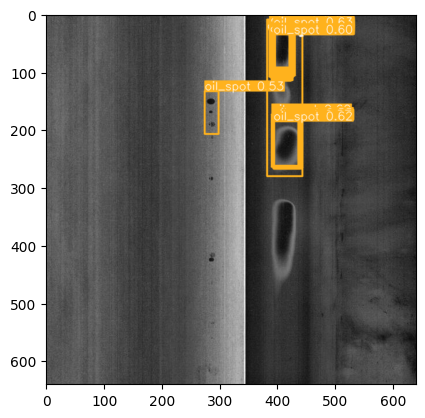

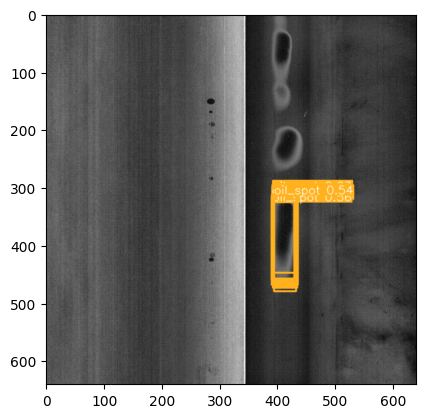

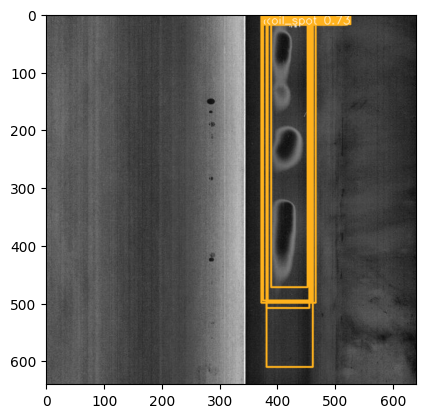

In [8]:
select_boxes = []
for id, box in enumerate(boxes):
    if conf[id] > 0.5:
        select_boxes.append(box)

for i in range(cluster_num):
    visualize_cluster_results(results, select_boxes, labels, i)